In [17]:

%load_ext autoreload
%autoreload 2

from pl_trainer import LightningModule
from data_module import MNISTDataModule
from torchvision import transforms
import torch.nn as nn
import lightning.pytorch as pl
import pandas as pd
import matplotlib.pyplot as plt
import torch

pl.seed_everything(42)

Seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


42

# Setting up Hyperparameters

In [ ]:
lr = 0.001   # Change learning rate here
batch_size = 64
max_epochs = 5

# Setting up Optimizer

In [19]:
optimizer = torch.optim.Adam # Change the optimizer here

# Defining Model Architecture 

In [20]:
def create_model():
    """
    Initializes the model as per the architecture in Table 1.
    """
    model = nn.Sequential(
        # First Convolutional Layer
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),  # 32 filters of 5x5, padding=2
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # MaxPooling with a 2x2 filter and stride of 2

        # Second Convolutional Layer
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # 64 filters of 3x3, padding=1
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # MaxPooling with a 2x2 filter and stride of 2

        # Third Convolutional Layer
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  # 128 filters of 3x3, padding=1
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # MaxPooling with a 2x2 filter and stride of 2

        # Flatten Layer
        nn.Flatten(),

        # Fully Connected Layers
        nn.Linear(4 * 4 * 128, 64),  # based on final feature map size after pooling
        nn.ReLU(),
        nn.Linear(64, 10)  # Output layer for 10 classes
    )
    
    return model

# Initialize the model, data module, and trainer
pl_model = LightningModule(model=create_model(), lr=lr, optimizer=optimizer)

# Setting up Dataloaders and Transformations

In [21]:
my_transforms = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])])


mnist_data = MNISTDataModule(batch_size=batch_size, transforms=my_transforms)

# Train Model

In [22]:
# Initialize CSVLogger
csv_logger = pl.loggers.CSVLogger(save_dir='logs/', name='mnist_logs', version=0)

# Set up the trainer
trainer = pl.Trainer(max_epochs=max_epochs, 
                     logger=csv_logger, 
                     check_val_every_n_epoch=1, 
                     enable_checkpointing=False,
                     deterministic=True)

# Train the model
trainer.fit(pl_model, mnist_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Bex\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\fabric\loggers\csv_logs.py:268: Experiment logs directory logs/mnist_logs\version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | model   | Sequential         | 224 K  | train
1 | loss_fn | CrossEntropyLoss   | 0      | train
2 | acc_fn  | MulticlassAccuracy | 0      | train
-------------------------------------------------------
224 K     Trainable params
0         Non-trainable params
224 K     Total params
0.900     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Bex\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Bex\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


# Plot Results

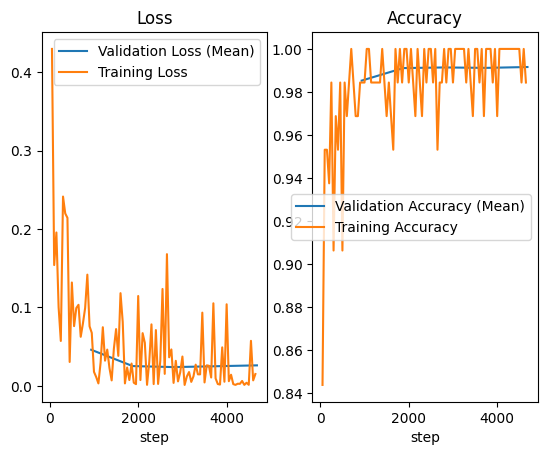

Final validation loss 0.0261
Final validation accuracy 0.9916


In [23]:
df = pd.read_csv('logs/mnist_logs/version_0/metrics.csv')

# Create a figure and axes objects
fig, ax = plt.subplots(1,2)

# Plot 'val_loss' on the axes
df.dropna(subset=['val_loss']).plot(x='step', y='val_loss', ax=ax[0], label='Validation Loss (Mean)')
# Plot 'train_loss' on the same axes
df.dropna(subset=['train_loss']).plot(x='step', y='train_loss', ax=ax[0], label='Training Loss')

# Plot 'val_loss' on the axes
df.dropna(subset=['val_acc']).plot(x='step', y='val_acc', ax=ax[1], label='Validation Accuracy (Mean)')
# Plot 'train_loss' on the same axes
df.dropna(subset=['train_acc']).plot(x='step', y='train_acc', ax=ax[1], label='Training Accuracy')

ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.show()

print("Final validation loss", round(df['val_loss'].iloc[-1], 4))
print("Final validation accuracy", round(df['val_acc'].iloc[-1], 4))